# Base-Level Algorithms Evaluation

In this notebook, recommendations obtained by base-level algorithms are evaluated (per user) using future data of test users.

This notebook is structured as follows:

    1 Data preparation
        1.1 Preparing test users
        1.2 Loading recommendations
        1.3 Recommendations evaluation
    2 Performance analysis
        2.1 NDCG@100
        2.2 MRR@100
        2.3 P@10
        2.4 R@10

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from ast import literal_eval
%matplotlib inline

In [2]:
# set default figsize
plt.rcParams['figure.figsize'] = [12, 4]

In [3]:
DATA_PATH = 'data/fstore/'

## 1 Data preparation

### 1.1 Preparing test users

In [4]:
test = pd.read_csv(DATA_PATH+'raw/future.csv')
test = test[test.user_eval_set=='test']
test = test.groupby('user_id')['item_id'].apply(list)
test.head()

user_id
0                                              [30958]
1                                              [31818]
2                  [19538, 22316, 25787, 31821, 35393]
3                         [26174, 30557, 30607, 34740]
4    [3845, 6921, 11083, 14902, 19632, 22967, 25219...
Name: item_id, dtype: object

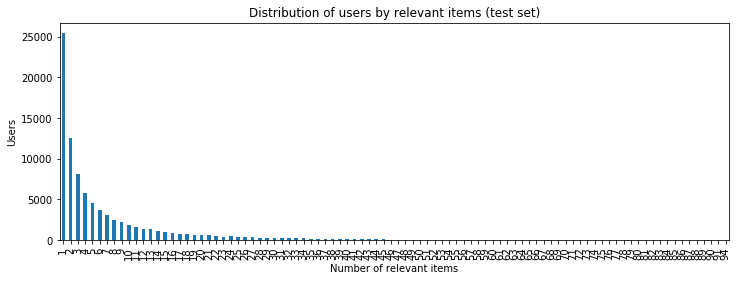

In [5]:
aux = test.apply(lambda x: len(x)).value_counts().sort_index()
aux.plot(kind='bar')
plt.xlim(-0.5, len(aux)-.5)
plt.title('Distribution of users by relevant items (test set)')
plt.xlabel('Number of relevant items')
plt.ylabel('Users')
plt.show()

### 1.2 Loading recommendations

In [6]:
alg_list = [
    'popular',
    'itemknn',
    'userknn',
    'als',
    'bpr'
]
alg_rec = {}
for alg in alg_list:
    alg_rec[alg] = pd.read_csv(DATA_PATH+'predictions/' + alg + '.csv')
    alg_rec[alg].set_index('user_id', inplace=True)

### 1.3 Recommendations evaluation

In [7]:
%%time
alg_perf = []
for u in test.index.values:
    
    perf_p_at_10 = []
    perf_r_at_10 = []
    perf_rr_at_100 = []
    perf_ndcg_at_100 = []
    
    for alg in alg_list:
        rec_list_relevance = [1 if x in test[u] else 0 for x in literal_eval(alg_rec[alg].loc[u].top100)]
        
        # P@10
        result = sum(rec_list_relevance[:10])/10
        perf_p_at_10.append([result, alg])
        
        # R@10
        result = sum(rec_list_relevance[:10])/len(test[u])
        perf_r_at_10.append([result, alg])
        
        # RR@100
        result = 0
        if 1 in rec_list_relevance:
            result = 1/(1+rec_list_relevance.index(1))
        perf_rr_at_100.append([result, alg])
        
        # NDCG@100
        dcg = 0
        for i in range(len(rec_list_relevance)):
            dcg += rec_list_relevance[i]/np.log2(2+i)        
        idcg = 0
        for i in range(len(test[u])):
            idcg += 1/np.log2(2+i)
        perf_ndcg_at_100.append([dcg/idcg, alg])
        
    perf_p_at_10.sort(reverse=True)
    perf_r_at_10.sort(reverse=True)
    perf_rr_at_100.sort(reverse=True)
    perf_ndcg_at_100.sort(reverse=True)
    alg_perf.append({
        'user_id': u,
        'P@10': perf_p_at_10,
        'R@10': perf_r_at_10,
        'RR@100': perf_rr_at_100,
        'NDCG@100': perf_ndcg_at_100
    })
    
perf = pd.DataFrame(alg_perf)

CPU times: user 32min 43s, sys: 4.78 s, total: 32min 48s
Wall time: 32min 49s


In [8]:
perf.to_csv(DATA_PATH+'rs_performance.csv', index=False)

## 2 Performance analysis

In [9]:
perf.head()

,NDCG@100,P@10,R@10,RR@100,user_id
0,"[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0, userknn], [0, popular], [0, itemknn], [0,...",0
1,"[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0, userknn], [0, popular], [0, itemknn], [0,...",1
2,"[[0.056316753775798256, popular], [0.054120274...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.015625, popular], [0.013157894736842105, b...",2
3,"[[0.06435448568843775, itemknn], [0.0630680314...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.0, userknn], [0.0, popular], [0.0, itemknn...","[[0.015151515151515152, itemknn], [0.013888888...",3
4,"[[0.412416442009166, bpr], [0.2353703166846384...","[[0.2, bpr], [0.1, itemknn], [0.1, als], [0.0,...","[[0.16666666666666666, bpr], [0.08333333333333...","[[0.3333333333333333, als], [0.2, bpr], [0.142...",4


### 2.1 NDCG@100

In [10]:
# how many users have optimal algorithm
metric = 'NDCG@100'
perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True]

49154

[]

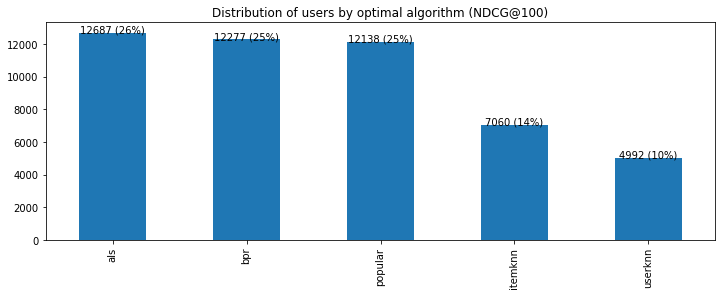

In [11]:
ax = perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][1]).value_counts().plot(kind='bar')
plt.title('Distribution of users by optimal algorithm (' + metric + ')')
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(height) + ' (' + str(int(round(100*height/perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True])))
                + '%)', (x + width/2, y + height + 10.14), ha='center')
plt.plot()

In [12]:
# how many users have multiple top performing algorithms (issue not considered in above chart)
perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0] == x[1][0]).value_counts()

False    48123
True      1031
Name: NDCG@100, dtype: int64

In [13]:
# average performance of algorithms (only users with optimal algorithm)
mean_perf = []
for alg in alg_list:
    mean_perf.append({
        'algorithm': alg,
        'mean '+metric: perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                            .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean(),
        'nonzero count '+metric: perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                            .apply(lambda x: len([1 for a in x if a[0] > 0 and a[1] == alg])).sum()
        })
    
pd.DataFrame(mean_perf).sort_values(by='mean '+metric, ascending=False)

,algorithm,mean NDCG@100,nonzero count NDCG@100
4,bpr,0.099885,26924
1,itemknn,0.089721,24262
3,als,0.088372,27034
0,popular,0.083950,26285
2,userknn,0.062427,21699


In [14]:
# average performance of algorithms (only users with optimal algorithm)
mean_perf = []
for alg in alg_list:
    mean_perf.append({
        'algorithm': alg,
        'count of users with nonzero '+metric: perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: len([1 for a in x if a[0] > 0 and a[1] == alg])).sum(),
        'mean '+metric+' (users with THIS optimal alg)': perf[perf[metric]\
                    .apply(lambda x: x[0][0] > 0 and x[0][1] == alg)][metric].apply(lambda x: x[0][0]).mean(),
        'mean '+metric+' (users with ANY optimal alg)': perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean(),
        'mean '+metric+' (all users)': perf[metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean()
        })
    
mean_perf = pd.DataFrame(mean_perf).sort_values(by='mean '+metric+' (all users)', ascending=False)
mean_perf

,algorithm,count of users with nonzero NDCG@100,mean NDCG@100 (all users),mean NDCG@100 (users with ANY optimal alg),mean NDCG@100 (users with THIS optimal alg)
4,bpr,26924,0.056535,0.099885,0.209459
1,itemknn,24262,0.050782,0.089721,0.270284
3,als,27034,0.050019,0.088372,0.200347
0,popular,26285,0.047516,0.083950,0.221236
2,userknn,21699,0.035334,0.062427,0.197550


In [15]:
print('Users with ANY optimal alg - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (users with ANY optimal alg)'].max())

print('Possible relative improvement: ', round(100 * perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (users with ANY optimal alg)'].max() -100, 2), '%')

Users with ANY optimal alg - mean NDCG@100 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.217542097252615
Baseline - best single algorithm:  0.09988541733021204
Possible relative improvement:  117.79 %


In [16]:
print('All users - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (all users)'].max())

print('Possible relative improvement: ', round(100 * perf[metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (all users)'].max() -100, 2), '%')

All users - mean NDCG@100 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.1231295685177449
Baseline - best single algorithm:  0.05653548665940356
Possible relative improvement:  117.79 %


### 2.2 MRR@100

In [17]:
# how many users have optimal algorithm
metric = 'RR@100'
perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True]

49154

[]

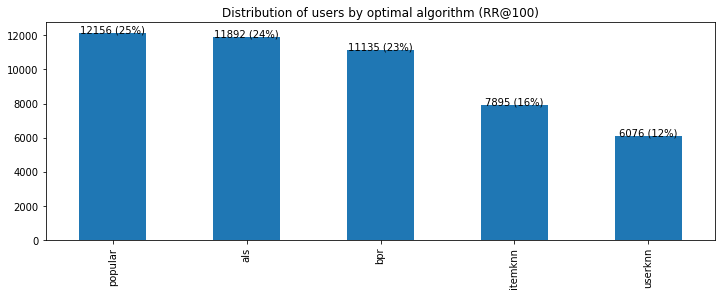

In [18]:
ax = perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][1]).value_counts().plot(kind='bar')
plt.title('Distribution of users by optimal algorithm (' + metric + ')')
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(height) + ' (' + str(int(round(100*height/perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True])))
                + '%)', (x + width/2, y + height + 10.14), ha='center')
plt.plot()

In [19]:
# how many users have multiple top performing algorithms (issue not considered in above chart)
perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0] == x[1][0]).value_counts()

False    46267
True      2887
Name: RR@100, dtype: int64

In [20]:
# average performance of algorithms (only users with optimal algorithm)
mean_perf = []
for alg in alg_list:
    mean_perf.append({
        'algorithm': alg,
        'count of users with nonzero '+metric: perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: len([1 for a in x if a[0] > 0 and a[1] == alg])).sum(),
        'mean '+metric+' (users with THIS optimal alg)': perf[perf[metric]\
                    .apply(lambda x: x[0][0] > 0 and x[0][1] == alg)][metric].apply(lambda x: x[0][0]).mean(),
        'mean '+metric+' (users with ANY optimal alg)': perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean(),
        'mean '+metric+' (all users)': perf[metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean()
        })
    
mean_perf = pd.DataFrame(mean_perf).sort_values(by='mean '+metric+' (all users)', ascending=False)
mean_perf

,algorithm,count of users with nonzero RR@100,mean RR@100 (all users),mean RR@100 (users with ANY optimal alg),mean RR@100 (users with THIS optimal alg)
4,bpr,26924,0.057585,0.101739,0.234925
1,itemknn,24262,0.050616,0.089427,0.351501
3,als,27034,0.048804,0.086225,0.230003
0,popular,26285,0.040096,0.070841,0.218849
2,userknn,21699,0.031236,0.055187,0.263680


In [21]:
print('Users with ANY optimal alg - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (users with ANY optimal alg)'].max())

print('Possible relative improvement: ', round(100 * perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (users with ANY optimal alg)'].max() -100, 2), '%')

Users with ANY optimal alg - mean RR@100 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.25203684485921796
Baseline - best single algorithm:  0.1017394415044024
Possible relative improvement:  147.73 %


In [22]:
print('All users - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (all users)'].max())

print('Possible relative improvement: ', round(100 * perf[metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (all users)'].max() -100, 2), '%')

All users - mean RR@100 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.14265371323534154
Baseline - best single algorithm:  0.05758487066127073
Possible relative improvement:  147.73 %


### 2.3 P@10

In [23]:
# how many users have optimal algorithm
metric = 'P@10'
perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True]

24805

[]

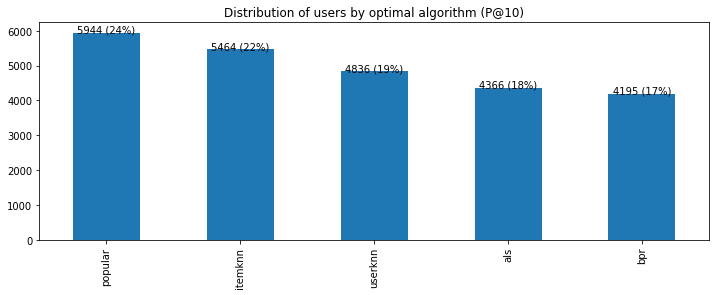

In [24]:
ax = perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][1]).value_counts().plot(kind='bar')
plt.title('Distribution of users by optimal algorithm (' + metric + ')')
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(height) + ' (' + str(int(round(100*height/perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True])))
                + '%)', (x + width/2, y + height + 3.14), ha='center')
plt.plot()

In [25]:
# how many users have multiple top performing algorithms (issue not considered in above chart)
perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0] == x[1][0]).value_counts()

False    16400
True      8405
Name: P@10, dtype: int64

In [26]:
# average performance of algorithms (only users with optimal algorithm)
mean_perf = []
for alg in alg_list:
    mean_perf.append({
        'algorithm': alg,
        'count of users with nonzero '+metric: perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: len([1 for a in x if a[0] > 0 and a[1] == alg])).sum(),
        'mean '+metric+' (users with THIS optimal alg)': perf[perf[metric]\
                    .apply(lambda x: x[0][0] > 0 and x[0][1] == alg)][metric].apply(lambda x: x[0][0]).mean(),
        'mean '+metric+' (users with ANY optimal alg)': perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean(),
        'mean '+metric+' (all users)': perf[metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean()
        })
    
mean_perf = pd.DataFrame(mean_perf).sort_values(by='mean '+metric+' (all users)', ascending=False)
mean_perf

,algorithm,count of users with nonzero P@10,mean P@10 (all users),mean P@10 (users with ANY optimal alg),mean P@10 (users with THIS optimal alg)
4,bpr,10417,0.015641,0.054759,0.145077
1,itemknn,9267,0.013685,0.047914,0.137573
3,als,9109,0.013189,0.046176,0.137380
0,popular,7597,0.009894,0.034638,0.114687
2,userknn,6320,0.008414,0.029458,0.115488


In [27]:
print('Users with ANY optimal alg - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (users with ANY optimal alg)'].max())

print('Possible relative improvement: ', round(100 * perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (users with ANY optimal alg)'].max() -100, 2), '%')

Users with ANY optimal alg - mean P@10 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.12901834307594356
Baseline - best single algorithm:  0.05475912114492833
Possible relative improvement:  135.61 %


In [28]:
print('All users - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (all users)'].max())

print('Possible relative improvement: ', round(100 * perf[metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (all users)'].max() -100, 2), '%')

All users - mean P@10 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.03685113536915366
Baseline - best single algorithm:  0.015640689051632205
Possible relative improvement:  135.61 %


### 2.4 R@10

In [29]:
# how many users have optimal algorithm
metric = 'R@10'
perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True]

24805

[]

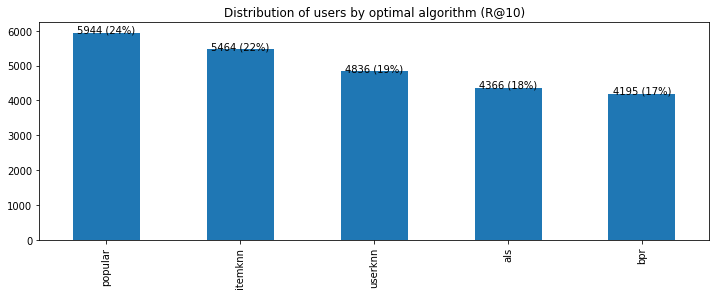

In [30]:
ax = perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][1]).value_counts().plot(kind='bar')
plt.title('Distribution of users by optimal algorithm (' + metric + ')')
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(str(height) + ' (' + str(int(round(100*height/perf[metric].apply(lambda x: x[0][0] > 0).value_counts()[True])))
                + '%)', (x + width/2, y + height + 3.14), ha='center')
plt.plot()

In [31]:
# how many users have multiple top performing algorithms (issue not considered in above chart)
perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0] == x[1][0]).value_counts()

False    16400
True      8405
Name: R@10, dtype: int64

In [32]:
# average performance of algorithms (only users with optimal algorithm)
mean_perf = []
for alg in alg_list:
    mean_perf.append({
        'algorithm': alg,
        'count of users with nonzero '+metric: perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: len([1 for a in x if a[0] > 0 and a[1] == alg])).sum(),
        'mean '+metric+' (users with THIS optimal alg)': perf[perf[metric]\
                    .apply(lambda x: x[0][0] > 0 and x[0][1] == alg)][metric].apply(lambda x: x[0][0]).mean(),
        'mean '+metric+' (users with ANY optimal alg)': perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean(),
        'mean '+metric+' (all users)': perf[metric]\
                    .apply(lambda x: [a for a in x if a[1] == alg][0][0]).mean()
        })
    
mean_perf = pd.DataFrame(mean_perf).sort_values(by='mean '+metric+' (all users)', ascending=False)
mean_perf

,algorithm,count of users with nonzero R@10,mean R@10 (all users),mean R@10 (users with ANY optimal alg),mean R@10 (users with THIS optimal alg)
4,bpr,10417,0.041299,0.144591,0.289642
1,itemknn,9267,0.040653,0.142329,0.392715
0,popular,7597,0.036831,0.128948,0.454138
3,als,9109,0.033645,0.117795,0.334322
2,userknn,6320,0.024579,0.086054,0.392379


In [33]:
print('Users with ANY optimal alg - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (users with ANY optimal alg)'].max())

print('Possible relative improvement: ', round(100 * perf[perf[metric].apply(lambda x: x[0][0] > 0)][metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (users with ANY optimal alg)'].max() -100, 2), '%')

Users with ANY optimal alg - mean R@10 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.379658627637859
Baseline - best single algorithm:  0.1445912868987824
Possible relative improvement:  162.57 %


In [34]:
print('All users - mean', metric, ':')
print('---------------------------------------------------------------')

print('Teoretical maximum that can be achieved with perfect classifier:',
    perf[metric].apply(lambda x: x[0][0]).mean())

print('Baseline - best single algorithm: ',
      mean_perf['mean '+metric+' (all users)'].max())

print('Possible relative improvement: ', round(100 * perf[metric].apply(lambda x: x[0][0]).mean()
      / mean_perf['mean '+metric+' (all users)'].max() -100, 2), '%')

All users - mean R@10 :
---------------------------------------------------------------
Teoretical maximum that can be achieved with perfect classifier: 0.10844079336001443
Baseline - best single algorithm:  0.04129919017461537
Possible relative improvement:  162.57 %
